
<div align="right"> </div>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:26px;color:red">Apprentissage en grande dimension
<div align="right"> </div>
<div align="center"><span style="font-family:Lucida Caligraphy;font-size:24px;color:green">Prédiction de la stratégie de la Reconnaissance des émotions et du genre à partir des audios</span></div><br><br>
<div align="center">
  <span style="font-family:Lucida Caligraphy;font-size:24px;color:blue">Aabouch Fatima Zahra</span><br><br>
  <span style="font-family:Lucida Caligraphy;font-size:24px;color:blue"> Megueya ElMame</span><br><br>
  <span style="font-family:Lucida Caligraphy;font-size:24px;color:blue">Asidah Nada</span><br><br>
  <span style="font-family:Lucida Caligraphy;font-size:24px;color:blue">Fatih Kawtar</span>
</div>
<hr>

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import time
from glob import glob
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import pickle

## Traitement des fichiers audios

In [173]:
root_dir = r"C:\Users\fzaab\Downloads\Audio_Speech_Actors_01-24"

files = {}  
sampling_rate = {}  

for actor_id in range(1, 25):
    actor_folder = os.path.join(root_dir, f"Actor_{actor_id:02d}")  

    if not os.path.exists(actor_folder):
        print(f"Dossier introuvable : {actor_folder}")
        continue

    audio_files = glob(os.path.join(actor_folder, "*.wav"))

    for file_path in audio_files:
        try:
            audio, sfreq = librosa.load(file_path, sr=None)

            files[file_path] = len(audio) / sfreq
            sampling_rate[file_path] = sfreq

        except Exception as e:
            print(f"Erreur lors du chargement de {file_path}: {e}")

print(f"Nombre total de fichiers traités : {len(files)}")


Nombre total de fichiers traités : 1440


### Vérifier que tous les fichiers audio  ont le même taux d'échantillonnage

In [175]:
all(value==48000 for value in sampling_rate.values())

True

In [177]:
# construction de DataFrame
df = pd.DataFrame()

for keys, values in files.items():
    df.at[keys, 'file_length'] = values
    df.at[keys, 'sampling_rate'] = sampling_rate[keys]  
    
df.head()

file_length  sampling_rate
C:\Users\fzaab\Downloads\Audio_Speech_Actors_01...     3.303292        48000.0
C:\Users\fzaab\Downloads\Audio_Speech_Actors_01...     3.336667        48000.0
C:\Users\fzaab\Downloads\Audio_Speech_Actors_01...     3.269917        48000.0
C:\Users\fzaab\Downloads\Audio_Speech_Actors_01...     3.169833        48000.0
C:\Users\fzaab\Downloads\Audio_Speech_Actors_01...     3.536854        48000.0

In [164]:
emotions_mapping = {
    "01": "Neutral",
    "02": "Calm",
    "03": "Happy",
    "04": "Sad",
    "05": "Angry",
    "06": "Fearful",
    "07": "Disgust",
    "08": "Surprised"
}

Processing example for emotion: Neutral


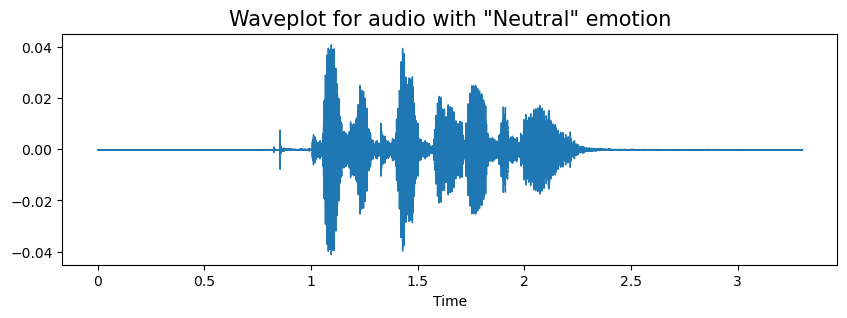

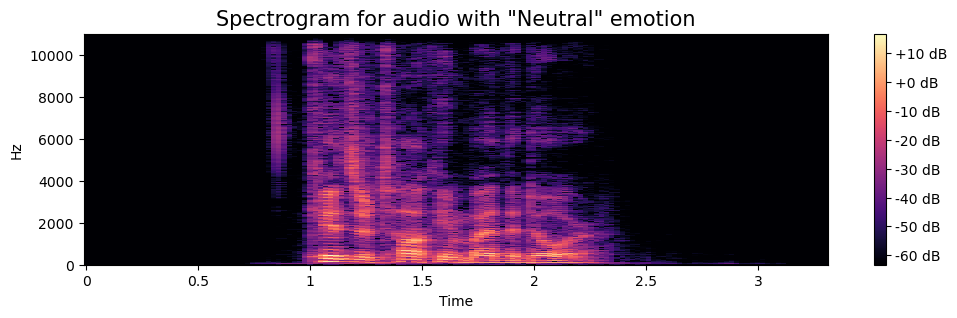

Processing example for emotion: Calm


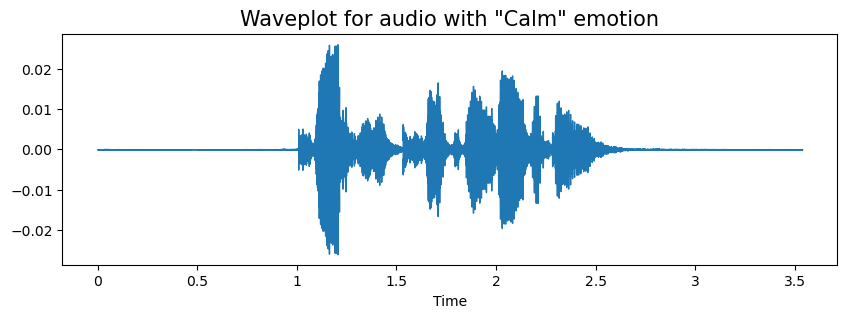

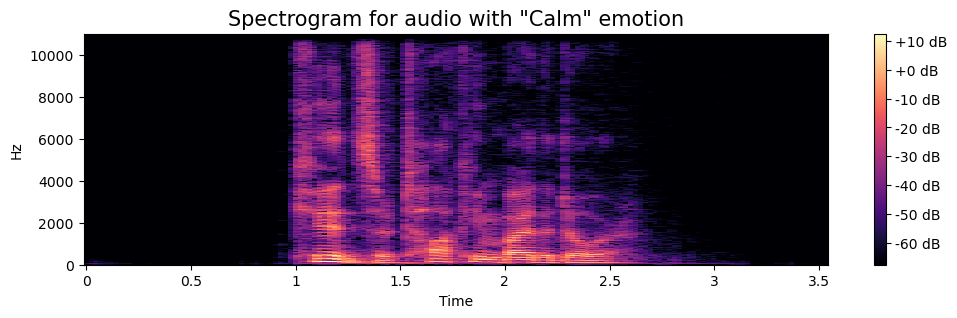

Processing example for emotion: Happy


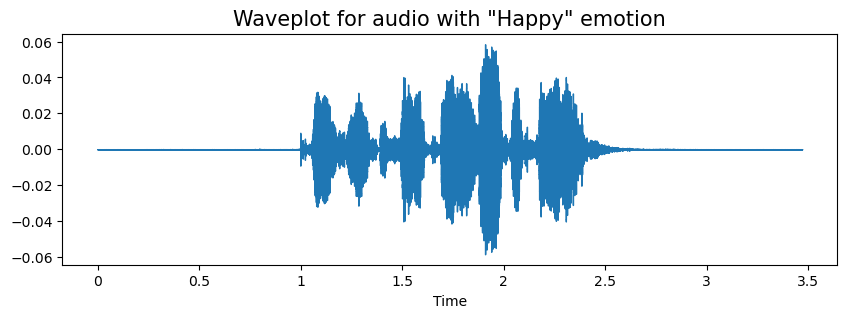

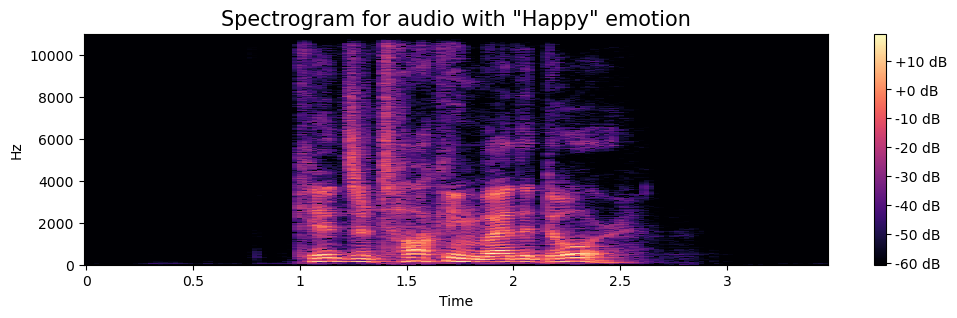

Processing example for emotion: Sad


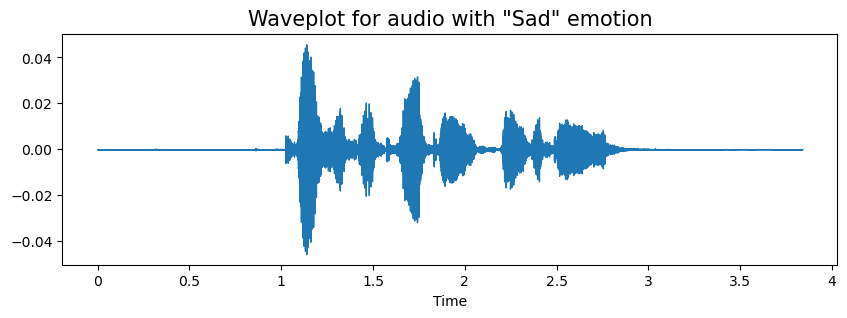

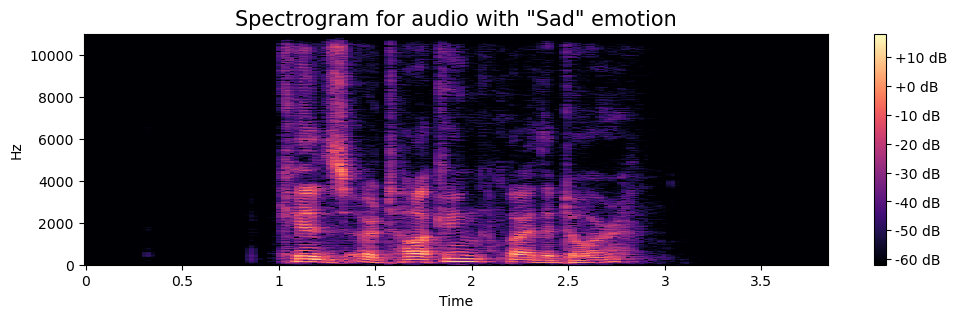

Processing example for emotion: Angry


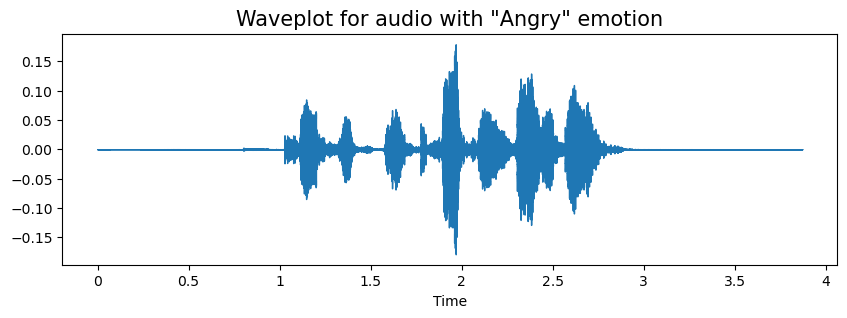

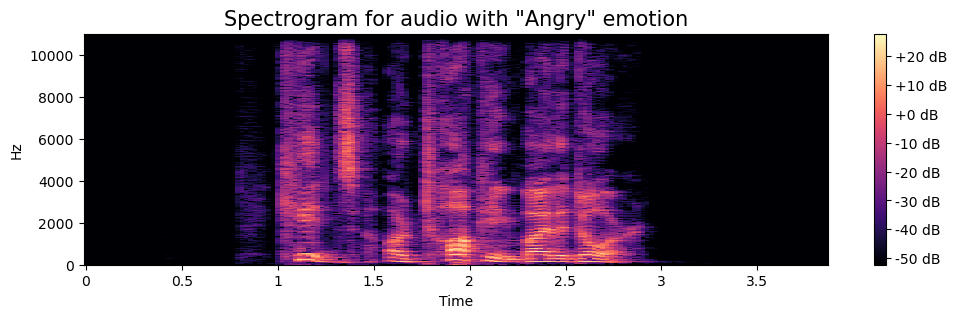

Processing example for emotion: Fearful


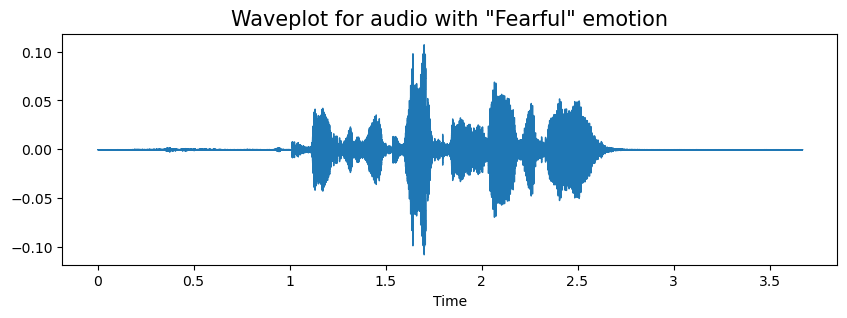

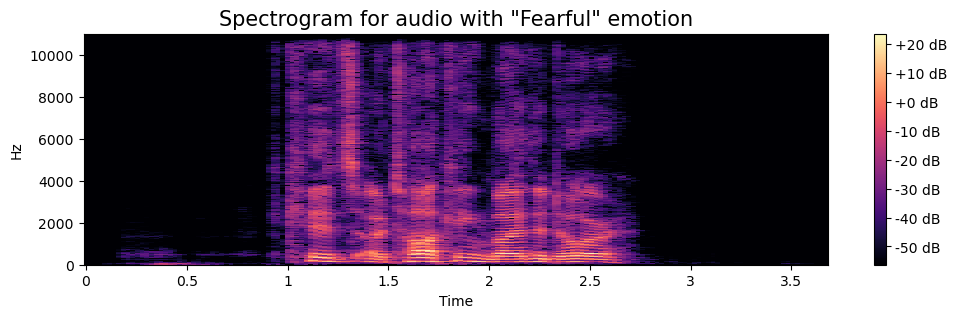

Processing example for emotion: Disgust


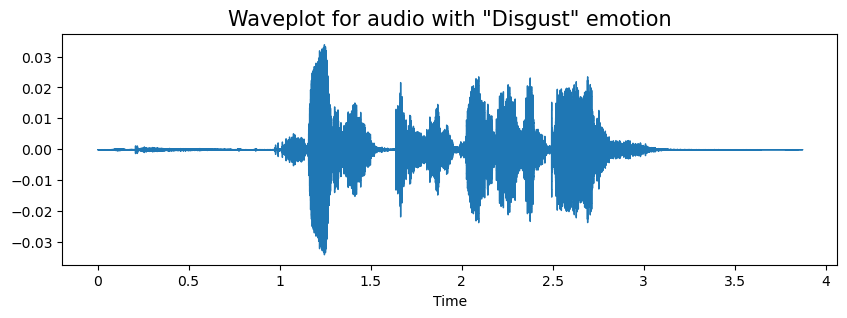

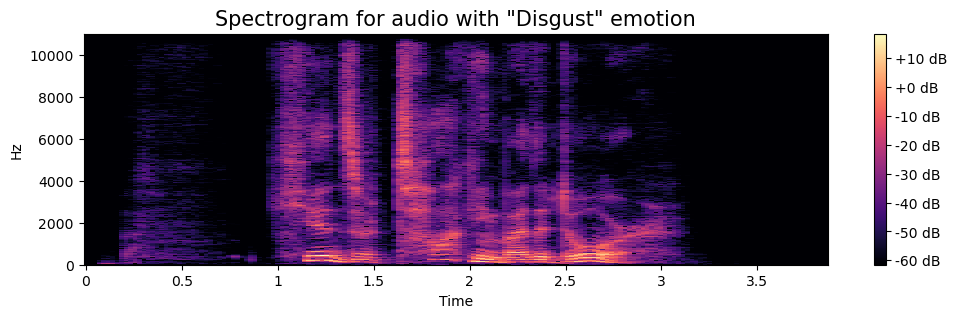

Processing example for emotion: Surprised


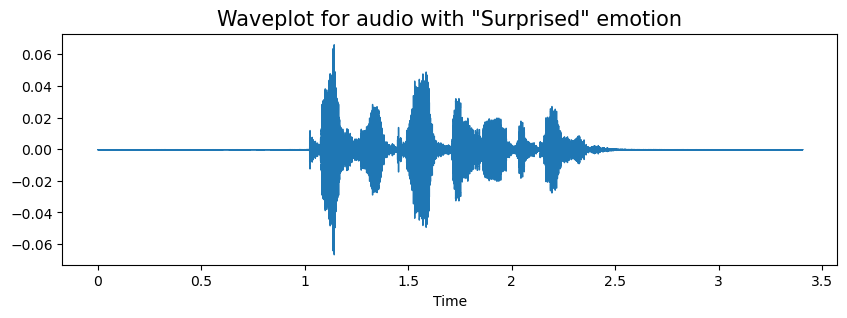

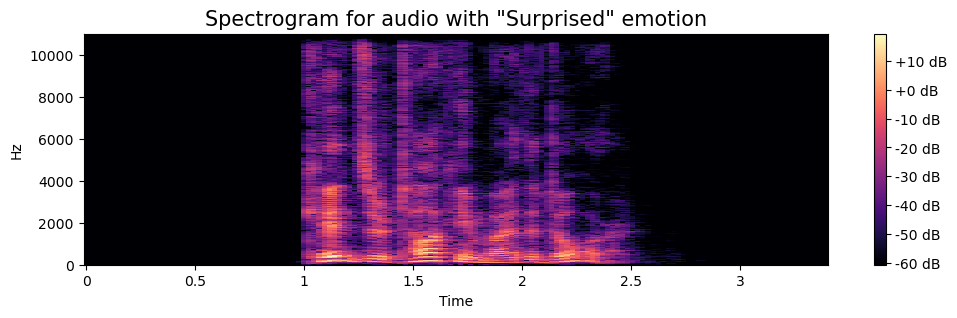

In [166]:
emotion_files = {}
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = emotions_mapping.get(emotion_code, "Unknown")
            
            if emotion not in emotion_files and emotion != "Unknown":
                emotion_files[emotion] = os.path.join(root, file)

# Création des waveplot:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with "{emotion}" emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

# création des spectrogrammes:
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)  
    Xdb = librosa.amplitude_to_db(abs(X))  
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram for audio with "{emotion}" emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Générer les visualisations pour chaque émotion
for emotion, path in emotion_files.items():
    print(f"Processing example for emotion: {emotion}")
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))

### Features

In [25]:
def extract_features(file_path, n_mfcc=19):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None, duration=2.5, offset=0.6)

        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        zcr = librosa.feature.zero_crossing_rate(y=audio).mean()

        rms = librosa.feature.rms(y=audio).mean()

        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate).mean()

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).mean()

        return {
            "MFCCs": mfccs.T,  
            "ZCR": zcr,
            "RMS": rms,
            "Spectral_Centroid": spectral_centroid,
            "Spectral_Bandwidth": spectral_bandwidth
        }
    except Exception as e:
        print(f"Erreur lors de l'extraction des caractéristiques pour le fichier {file_path}: {e}")
        return None

list_data_frame = []

for file_path in df.index:
    features = extract_features(file_path)

    if features is None:
        print(f"Erreur lors du traitement de {file_path}")
        continue

    mfccs = features["MFCCs"]
    frame = pd.DataFrame(mfccs, columns=[f'mfcc{x}' for x in range(mfccs.shape[1])])

    frame["ZCR"] = features["ZCR"]
    frame["RMS"] = features["RMS"]
    frame["Spectral_Centroid"] = features["Spectral_Centroid"]
    frame["Spectral_Bandwidth"] = features["Spectral_Bandwidth"]

    file_name = os.path.basename(file_path)
    parts = file_name.split("-")
    frame['ID_ACTOR_GENDER'] = parts[6][:2]
    frame['ID_EMOTION'] = parts[2]
    frame['ID_EMOTION_INTENSITY'] = parts[3]

    list_data_frame.append(frame)

identifiers_df = pd.concat(list_data_frame, ignore_index=True)

print(identifiers_df.head())


        mfcc0  mfcc1  mfcc2  mfcc3  mfcc4  mfcc5  mfcc6  mfcc7  mfcc8  mfcc9  \
0 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...  mfcc16  mfcc17  mfcc18       ZCR       RMS  Spectral_Centroid  \
0  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
1  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
2  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
3  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
4  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   

   Spectral_Bandwidth  ID_ACTOR_GENDER  ID_EMOTION  ID_EMOTION_INTENSITY  
0    

In [27]:
identifiers_df.head()

mfcc0  mfcc1  mfcc2  mfcc3  mfcc4  mfcc5  mfcc6  mfcc7  mfcc8  mfcc9  \
0 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...  mfcc16  mfcc17  mfcc18       ZCR       RMS  Spectral_Centroid  \
0  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
1  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
2  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
3  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   
4  ...     0.0     0.0     0.0  0.063836  0.002797        6057.807893   

   Spectral_Bandwidth  ID_ACTOR_GENDER  ID_EMOTION  ID_EMOTION_INTENSITY  
0         5118.362961               01          01                    01  
1         5118.362961               01          01                    01  
2         5118.362961               01          01                    01  
3         5118.362961               01          01                    01  
4         5118.362961               01          01                    01  

[5 rows x 26 columns]

In [29]:
identifiers_df['LABEL_GENDER'] = list(map(lambda x: 'male' if int(x)%2 == 1 else 'female',
                                         identifiers_df.ID_ACTOR_GENDER))


In [31]:
identifiers_df['LABEL_EMOTION'] = identifiers_df.ID_EMOTION.map({'01':'neutral',
                                                                 '02':'calm',
                                                                 '03':'happy',
                                                                 '04':'sad',
                                                                 '05':'angry',
                                                                 '06':'fearful',
                                                                 '07':'disgust',
                                                                 '08':'surprised'})

In [33]:
identifiers_df['LABEL_INTENSITY'] = identifiers_df.ID_EMOTION_INTENSITY.map({'01':'normal',
                                                                             '02':'strong'})

In [35]:
identifiers_df['LABEL_GENDER_EMOTION'] = identifiers_df['LABEL_GENDER'] + '_' + identifiers_df['LABEL_EMOTION']

In [37]:
identifiers_df['LABEL_INTENSITY'] = identifiers_df.ID_EMOTION_INTENSITY.map({'01':'normal',
                                                                             '02':'strong'})

In [39]:
df_final = identifiers_df.copy()

In [41]:
df_final.head()

mfcc0  mfcc1  mfcc2  mfcc3  mfcc4  mfcc5  mfcc6  mfcc7  mfcc8  mfcc9  \
0 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4 -861.932068    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...       RMS  Spectral_Centroid  Spectral_Bandwidth  ID_ACTOR_GENDER  \
0  ...  0.002797        6057.807893         5118.362961               01   
1  ...  0.002797        6057.807893         5118.362961               01   
2  ...  0.002797        6057.807893         5118.362961               01   
3  ...  0.002797        6057.807893         5118.362961               01   
4  ...  0.002797        6057.807893         5118.362961               01   

   ID_EMOTION  ID_EMOTION_INTENSITY  LABEL_GENDER  LABEL_EMOTION  \
0          01                    01          male        neutral   
1          01                    01          male        neutral   
2          01                    01          male        neutral   
3          01                    01          male        neutral   
4          01                    01          male        neutral   

   LABEL_INTENSITY  LABEL_GENDER_EMOTION  
0           normal          male_neutral  
1           normal          male_neutral  
2           normal          male_neutral  
3           normal          male_neutral  
4           normal          male_neutral  

[5 rows x 30 columns]

In [43]:
df_final.dtypes

mfcc0                   float32
mfcc1                   float32
mfcc2                   float32
mfcc3                   float32
mfcc4                   float32
mfcc5                   float32
mfcc6                   float32
mfcc7                   float32
mfcc8                   float32
mfcc9                   float32
mfcc10                  float32
mfcc11                  float32
mfcc12                  float32
mfcc13                  float32
mfcc14                  float32
mfcc15                  float32
mfcc16                  float32
mfcc17                  float32
mfcc18                  float32
ZCR                     float64
RMS                     float32
Spectral_Centroid       float64
Spectral_Bandwidth      float64
ID_ACTOR_GENDER          object
ID_EMOTION               object
ID_EMOTION_INTENSITY     object
LABEL_GENDER             object
LABEL_EMOTION            object
LABEL_INTENSITY          object
LABEL_GENDER_EMOTION     object
dtype: object

<Axes: xlabel='LABEL_GENDER', ylabel='count'>

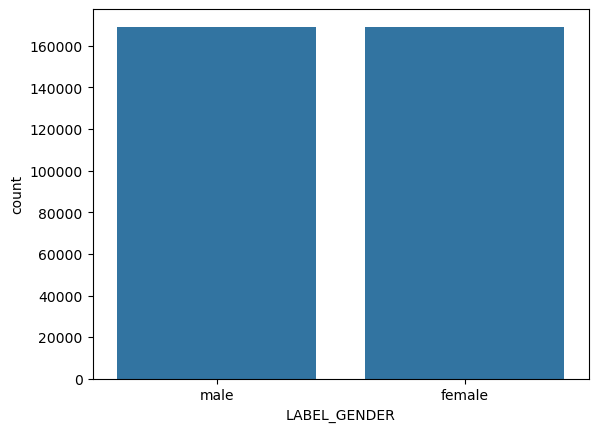

In [45]:
sns.countplot(x = 'LABEL_GENDER', data = df_final)

In [47]:
feature_columns = [col for col in df_final.columns if col.startswith('mfcc') or col in ['ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']]

print(df_final[feature_columns].describe())


               mfcc0          mfcc1          mfcc2          mfcc3  \
count  338322.000000  338322.000000  338322.000000  338322.000000   
mean     -552.588928      89.682724      -9.141793      13.328876   
std       178.819260      71.044617      34.119362      29.225040   
min     -1085.457520    -154.917603    -153.276764    -105.053955   
25%      -689.554825      23.645431     -32.388601      -1.581285   
50%      -536.653015      95.151352      -0.537599       9.530658   
75%      -416.925186     148.684383      13.747829      28.880832   
max       -27.104719     279.854706      98.801514     151.355972   

               mfcc4          mfcc5          mfcc6          mfcc7  \
count  338322.000000  338322.000000  338322.000000  338322.000000   
mean       -2.056951      10.071452     -13.817789       0.170736   
std        23.581223      19.951759      22.489758      14.698780   
min      -120.306259     -93.364418    -104.263802     -66.060150   
25%       -15.975573       0.0000

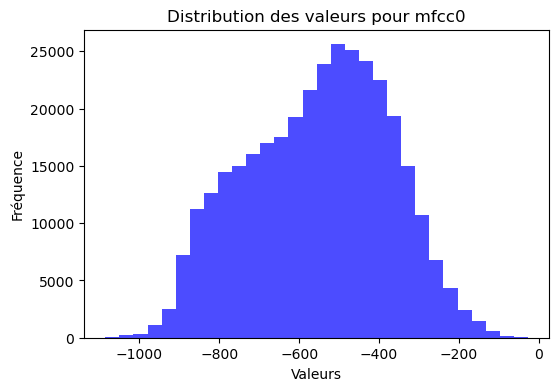

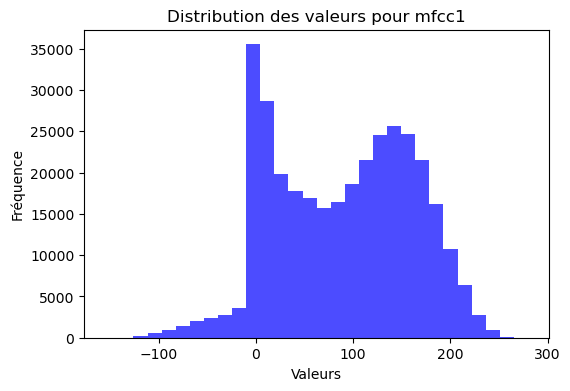

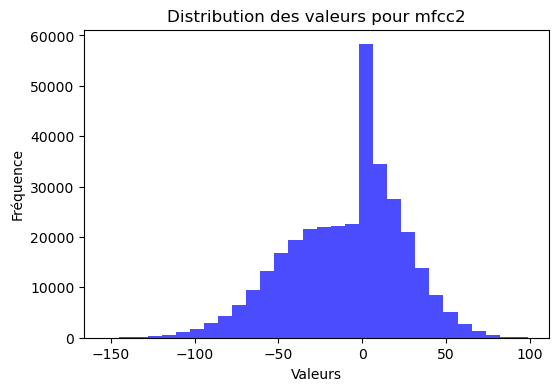

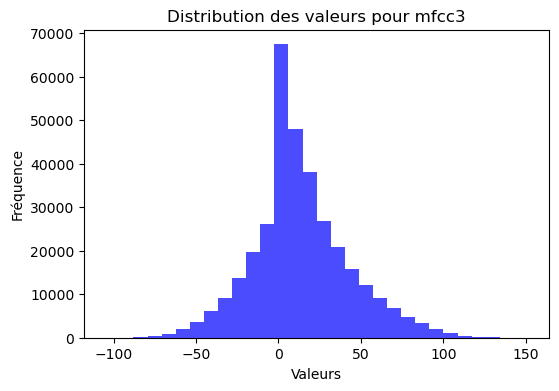

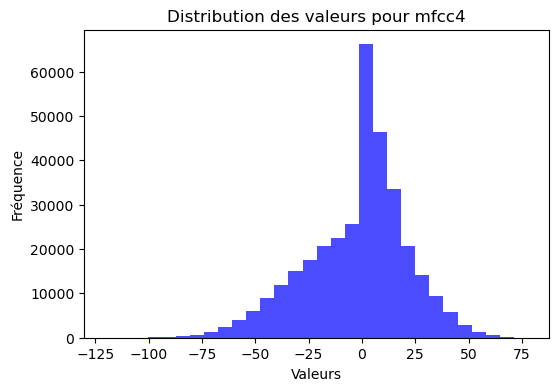

In [49]:
# les distributions pour quelques colonnes MFCC
for col in feature_columns[:5]:  
    plt.figure(figsize=(6, 4))
    plt.hist(df_final[col], bins=30, alpha=0.7, color='blue')
    plt.title(f'Distribution des valeurs pour {col}')
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.show()


## Normalisation

In [52]:
feature_columns = [col for col in df_final.columns if col.startswith('mfcc') or col in ['ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']]

scaler = StandardScaler()
df_final[feature_columns] = scaler.fit_transform(df_final[feature_columns])

print(df_final[feature_columns].describe())


              mfcc0         mfcc1         mfcc2         mfcc3         mfcc4  \
count  3.383220e+05  3.383220e+05  3.383220e+05  3.383220e+05  3.383220e+05   
mean   2.607604e-16 -5.245451e-16  1.680157e-17 -3.427521e-17  2.016189e-18   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -2.979799e+00 -3.443063e+00 -4.224729e+00 -4.050652e+00 -5.014280e+00   
25%   -7.659128e-01 -9.295596e-01 -6.813854e-01 -5.101741e-01 -5.902095e-01   
50%    8.911358e-02  7.697805e-02  2.521969e-01 -1.299618e-01  1.234363e-01   
75%    7.586312e-01  8.305242e-01  6.709160e-01  5.321343e-01  6.161111e-01   
max    2.938506e+00  2.676915e+00  3.163918e+00  4.722811e+00  3.388183e+00   

              mfcc5         mfcc6         mfcc7         mfcc8         mfcc9  \
count  3.383220e+05  3.383220e+05  3.383220e+05  3.383220e+05  3.383220e+05   
mean  -4.368409e-17 -1.276920e-17 -1.209713e-17 -8.064755e-17 -1.306322e-16   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.

In [54]:
df_final.head()

mfcc0     mfcc1     mfcc2     mfcc3     mfcc4    mfcc5     mfcc6  \
0 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
1 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
2 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
3 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
4 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   

      mfcc7     mfcc8     mfcc9  ...       RMS  Spectral_Centroid  \
0 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
1 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
2 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
3 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
4 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   

   Spectral_Bandwidth  ID_ACTOR_GENDER  ID_EMOTION  ID_EMOTION_INTENSITY  \
0            1.256412               01          01                    01   
1            1.256412               01          01                    01   
2            1.256412               01          01                    01   
3            1.256412               01          01                    01   
4            1.256412               01          01                    01   

   LABEL_GENDER  LABEL_EMOTION  LABEL_INTENSITY  LABEL_GENDER_EMOTION  
0          male        neutral           normal          male_neutral  
1          male        neutral           normal          male_neutral  
2          male        neutral           normal          male_neutral  
3          male        neutral           normal          male_neutral  
4          male        neutral           normal          male_neutral  

[5 rows x 30 columns]

C:\Users\fzaab\AppData\Local\Temp\ipykernel_23844\1496444664.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


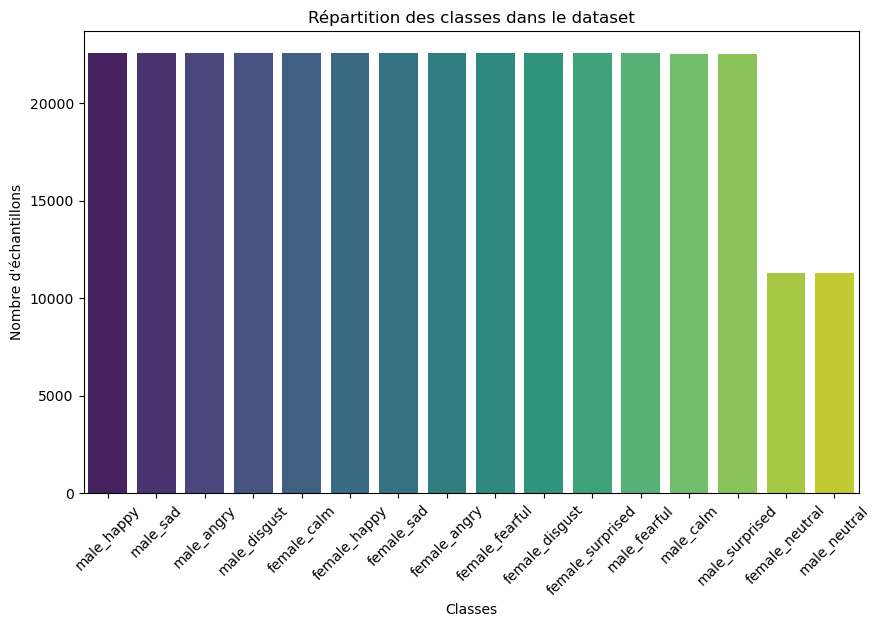

In [56]:
label_counts = df_final['LABEL_GENDER_EMOTION'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des classes dans le dataset")
plt.xticks(rotation=45)
plt.show()


In [60]:
X = df_final.drop(columns=["LABEL_EMOTION"])  
y = df_final["LABEL_EMOTION"]  

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

df_balanced = X_resampled.copy()
df_balanced["LABEL_EMOTION"] = y_resampled

print(df_balanced["LABEL_EMOTION"].value_counts())


LABEL_EMOTION
neutral      45120
calm         45120
happy        45120
sad          45120
angry        45120
fearful      45120
disgust      45120
surprised    45120
Name: count, dtype: int64


In [62]:
df_balanced.head()

mfcc0     mfcc1     mfcc2     mfcc3     mfcc4    mfcc5     mfcc6  \
0 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
1 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
2 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
3 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   
4 -1.729846 -1.262399  0.267954 -0.456068  0.087224 -0.50481  0.614402   

      mfcc7     mfcc8     mfcc9  ...       RMS  Spectral_Centroid  \
0 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
1 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
2 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
3 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   
4 -0.011615  0.677912  0.581952  ... -0.641941           2.101768   

   Spectral_Bandwidth  ID_ACTOR_GENDER  ID_EMOTION  ID_EMOTION_INTENSITY  \
0            1.256412               01          01                    01   
1            1.256412               01          01                    01   
2            1.256412               01          01                    01   
3            1.256412               01          01                    01   
4            1.256412               01          01                    01   

   LABEL_GENDER  LABEL_INTENSITY  LABEL_GENDER_EMOTION  LABEL_EMOTION  
0          male           normal          male_neutral        neutral  
1          male           normal          male_neutral        neutral  
2          male           normal          male_neutral        neutral  
3          male           normal          male_neutral        neutral  
4          male           normal          male_neutral        neutral  

[5 rows x 30 columns]

In [114]:
print(df_balanced['LABEL_GENDER_EMOTION'].value_counts())

LABEL_GENDER_EMOTION
male_neutral        22675
female_surprised    22580
female_calm         22573
female_fearful      22563
male_happy          22560
male_sad            22560
male_angry          22560
male_disgust        22560
female_happy        22560
female_sad          22560
female_angry        22560
female_disgust      22560
male_fearful        22557
male_calm           22547
male_surprised      22540
female_neutral      22445
Name: count, dtype: int64



## logistic Regression

In [65]:
features = ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
            'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']

X = df_balanced[features].values  
Y = df_balanced['LABEL_GENDER_EMOTION'].values  

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded)

model = LogisticRegression(max_iter=500, solver='lbfgs', random_state=42)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy du modèle de régression logistique : {accuracy:.4f}")

print(classification_report(Y_test, Y_pred))


Accuracy du modèle de régression logistique : 0.3342
              precision    recall  f1-score   support

           0       0.41      0.38      0.39      4512
           1       0.36      0.47      0.41      4515
           2       0.36      0.43      0.39      4512
           3       0.36      0.30      0.33      4513
           4       0.29      0.23      0.25      4512
           5       0.37      0.45      0.41      4489
           6       0.21      0.19      0.20      4512
           7       0.36      0.37      0.37      4516
           8       0.51      0.46      0.48      4512
           9       0.42      0.58      0.49      4509
          10       0.27      0.36      0.31      4512
          11       0.25      0.13      0.17      4511
          12       0.32      0.31      0.31      4512
          13       0.32      0.40      0.35      4535
          14       0.12      0.08      0.09      4512
          15       0.28      0.23      0.25      4508

    accuracy               

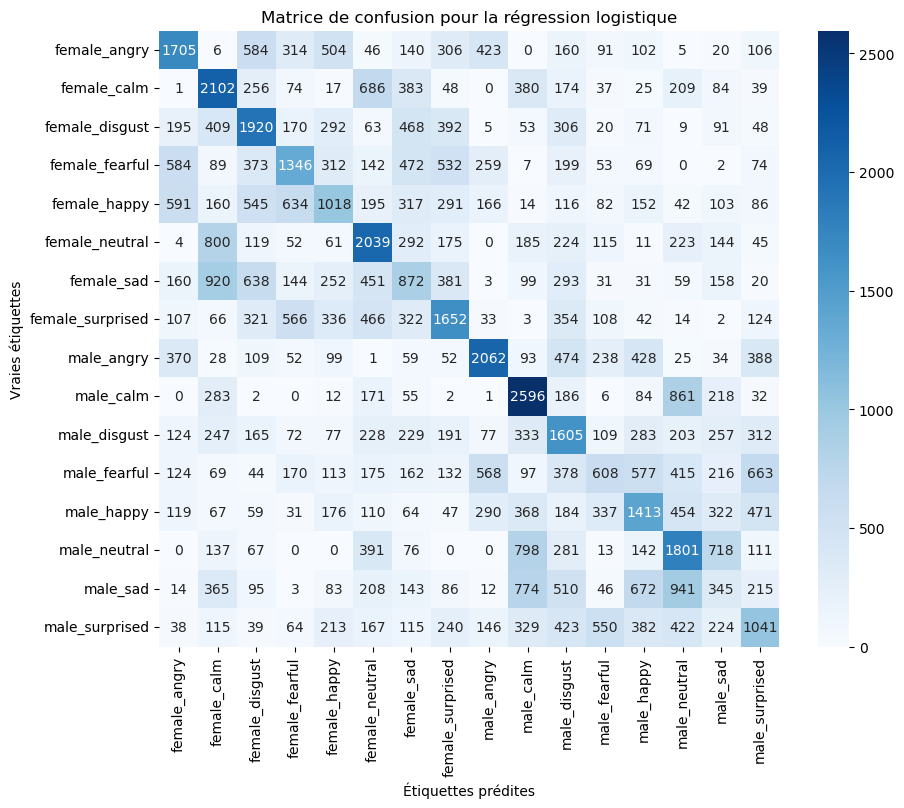

In [69]:
conf_matrix = confusion_matrix(Y_test, Y_pred)

class_names = encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Matrice de confusion pour la régression logistique')
plt.xlabel('Étiquettes prédites')
plt.ylabel('Vraies étiquettes')
plt.show()


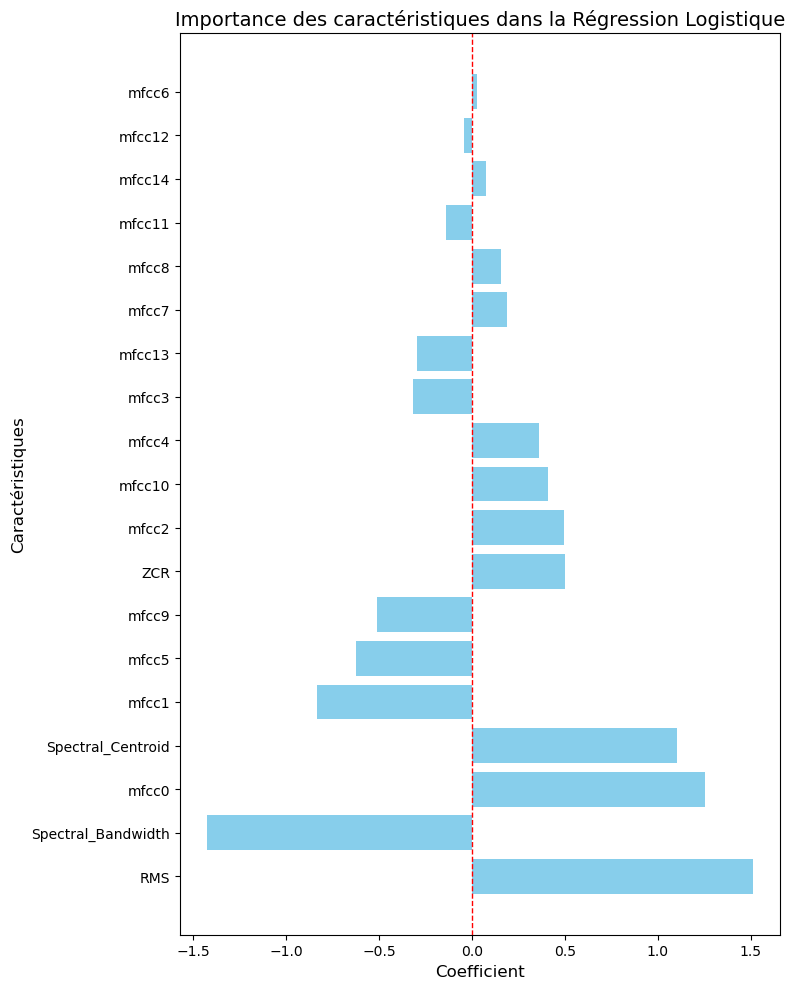

In [71]:
coefficients = model.coef_[0]  

feature_names = ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
                 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']

sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

plt.figure(figsize=(8, 10))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.title("Importance des caractéristiques dans la Régression Logistique", fontsize=14)
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("Caractéristiques", fontsize=12)
plt.axvline(0, color='red', linestyle='--', linewidth=1)  
plt.tight_layout()
plt.show()


## XGBoost

In [74]:
features = ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
            'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']

X = df_balanced[features].values  
Y = df_balanced['LABEL_GENDER_EMOTION'].values  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_trainG, X_testG, Y_trainG, Y_testG = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

print(f"Taille entraînement : {X_trainG.shape}, Taille test : {X_testG.shape}")

Taille entraînement : (288768, 19), Taille test : (72192, 19)


In [76]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb.fit(X_trainG, Y_trainG)

Y_pred = xgb.predict(X_testG)

C:\Users\fzaab\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [78]:
from sklearn.metrics import confusion_matrix
accuracy1 = accuracy_score(Y_testG, Y_pred)
print(f"Précision du modèle XGBoost : {accuracy1:.2f}")


Précision du modèle XGBoost : 1.00


In [80]:
xgb1 =  XGBClassifier(n_estimators=100, max_depth=4, reg_lambda=5, learning_rate=0.03)

xgb1.fit(X_trainG, Y_trainG)

Y_pred = xgb1.predict(X_testG)

In [82]:
from sklearn.metrics import confusion_matrix
accuracy2 = accuracy_score(Y_testG, Y_pred)
print(f"Précision du modèle XGBoost : {accuracy2:.2f}")


Précision du modèle XGBoost : 0.63


Rapport de classification :
                  precision    recall  f1-score   support

    female_angry       0.77      0.58      0.66      4516
     female_calm       0.63      0.75      0.69      4589
  female_disgust       0.64      0.66      0.65      4537
  female_fearful       0.66      0.68      0.67      4629
    female_happy       0.63      0.39      0.48      4462
  female_neutral       0.63      0.98      0.77      4473
      female_sad       0.66      0.35      0.45      4478
female_surprised       0.51      0.81      0.63      4615
      male_angry       0.78      0.70      0.74      4366
       male_calm       0.62      0.74      0.68      4496
    male_disgust       0.63      0.41      0.49      4554
    male_fearful       0.77      0.61      0.68      4445
      male_happy       0.57      0.53      0.55      4525
    male_neutral       0.55      0.91      0.68      4565
        male_sad       0.87      0.43      0.58      4505
  male_surprised       0.53      0.58      

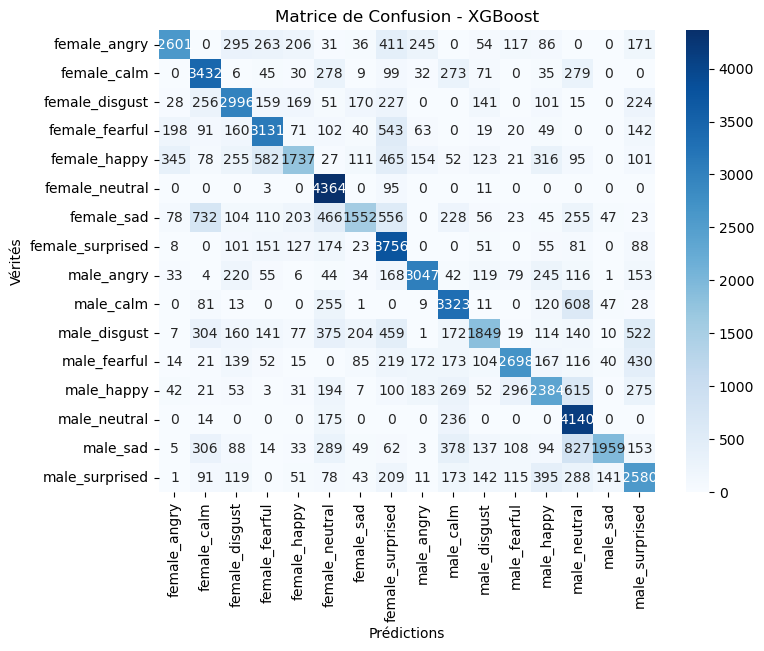

In [84]:
print("Rapport de classification :")
print(classification_report(Y_testG, Y_pred, target_names=encoder.classes_))

conf_matrix = confusion_matrix(Y_testG, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matrice de Confusion - XGBoost")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

## Random Forest

In [87]:
features = ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
            'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']

X = df_balanced[features].values  
Y = df_balanced['LABEL_GENDER_EMOTION'].values  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)

X_trainF, X_testF, Y_trainF, Y_testF = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42, stratify=Y_encoded)

print(f"Taille entraînement : {X_train.shape}, Taille test : {X_test.shape}")


Taille entraînement : (288768, 19), Taille test : (72192, 19)


In [89]:
modelF = RandomForestClassifier(
    n_estimators=100,  
    max_depth=10,  
    min_samples_split=10,  
    min_samples_leaf=5,  
    max_features='sqrt',  
    random_state=42,
    class_weight='balanced'  
)

modelF.fit(X_trainF, Y_trainF)

Y_predF = modelF.predict(X_testF)

accuracy = accuracy_score(Y_testF, Y_predF)
print(f"Accuracy du modèle Random Forest régularisé : {accuracy:.4f}")

print(classification_report(Y_testF, Y_predF))


Accuracy du modèle Random Forest régularisé : 0.7601
              precision    recall  f1-score   support

           0       0.90      0.68      0.78      4512
           1       0.82      0.85      0.83      4515
           2       0.75      0.81      0.78      4512
           3       0.75      0.70      0.73      4513
           4       0.82      0.72      0.77      4512
           5       0.68      0.98      0.80      4489
           6       0.94      0.60      0.73      4512
           7       0.54      0.81      0.65      4516
           8       0.89      0.75      0.82      4512
           9       0.74      0.81      0.78      4509
          10       0.76      0.67      0.71      4512
          11       0.96      0.74      0.84      4511
          12       0.69      0.74      0.71      4512
          13       0.72      0.99      0.83      4535
          14       0.93      0.62      0.74      4512
          15       0.66      0.69      0.67      4508

    accuracy               

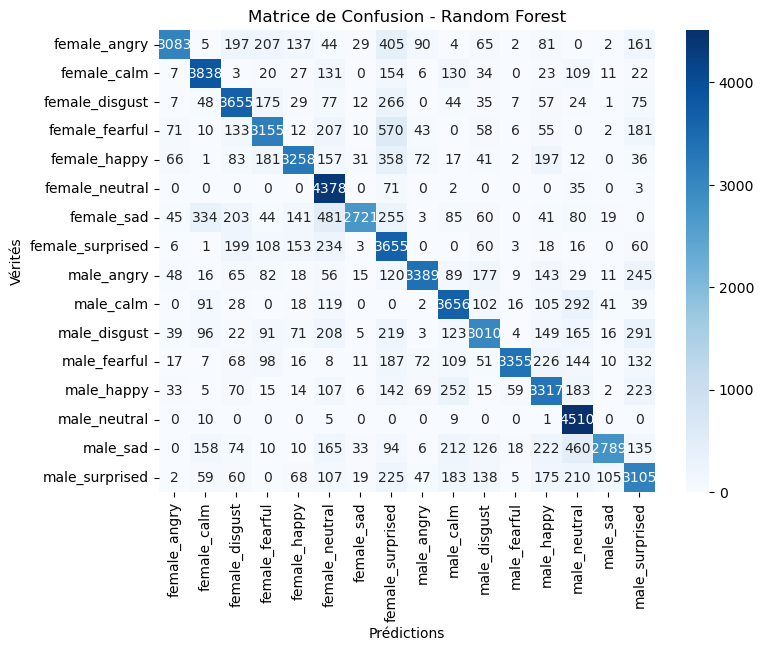

In [91]:
cm = confusion_matrix(Y_testF, Y_predF)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Matrice de Confusion - Random Forest")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()


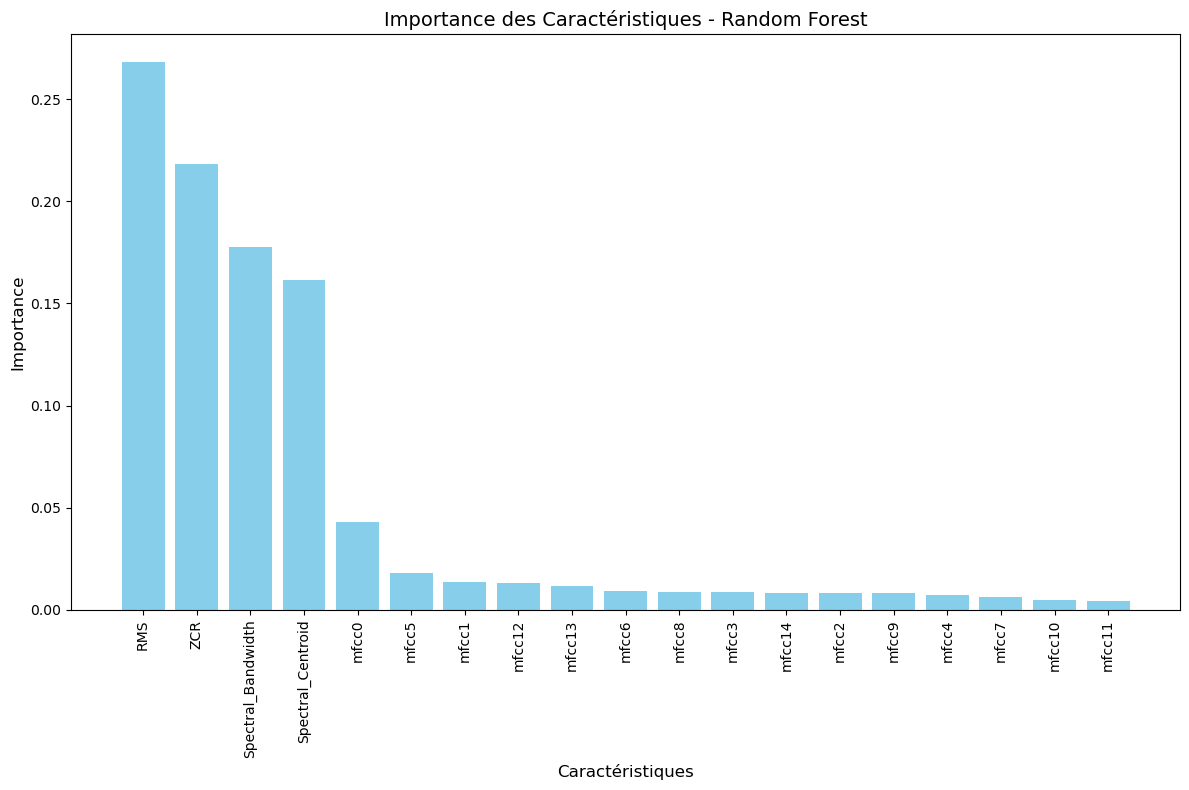

In [93]:
import numpy as np
import matplotlib.pyplot as plt

importances = modelF.feature_importances_

feature_names = ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
                 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_names)), importances[indices], align="center", color="skyblue")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90, fontsize=10)
plt.xlabel("Caractéristiques", fontsize=12)
plt.ylabel("Importance", fontsize=12)
plt.title("Importance des Caractéristiques - Random Forest", fontsize=14)
plt.tight_layout()
plt.show()


## Modèle LSTM

In [98]:
df = df_balanced

features = ['mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
            'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'ZCR', 'RMS', 'Spectral_Centroid', 'Spectral_Bandwidth']

X = df[features].values
y = df['LABEL_GENDER_EMOTION'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

X = X.reshape((X.shape[0], 1, X.shape[1]))  

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de Y_train:", Y_train.shape)
print("Shape de Y_test:", Y_test.shape)

model = Sequential()

model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(Y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  

print("Exemples de prédictions :")
print("Prédictions:", y_pred_labels[:10])
print("Véritables labels:", np.argmax(Y_test, axis=1)[:10])


Shape de X_train: (288768, 1, 19)
Shape de X_test: (72192, 1, 19)
Shape de Y_train: (288768, 16)
Shape de Y_test: (72192, 16)


C:\Users\fzaab\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          75,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,072 (332.31 KB)

 Trainable params: 85,072 (332.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.3211 - loss: 1.9648 - val_accuracy: 0.4496 - val_loss: 1.5555
Epoch 2/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.4271 - loss: 1.6244 - val_accuracy: 0.5049 - val_loss: 1.4051
Epoch 3/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.4589 - loss: 1.5165 - val_accuracy: 0.5394 - val_loss: 1.2945
Epoch 4/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 51s 6ms/step - accuracy: 0.4849 - loss: 1.4413 - val_accuracy: 0.5726 - val_loss: 1.2030
Epoch 5/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.5057 - loss: 1.3773 - val_accuracy: 0.6062 - val_loss: 1.1261
Epoch 6/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.5229 - loss: 1.3305 - val_accuracy: 0.6317 - val_loss: 1.0612
Epoch 7/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - accuracy: 0.5372 - loss: 1.2854 - val_accuracy: 0.6493 - val_loss: 1.0157
Epoch 8/100
9024/9024 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.5473 -

In [100]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9419 - loss: 0.2632
Test Accuracy: 94.07%


2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


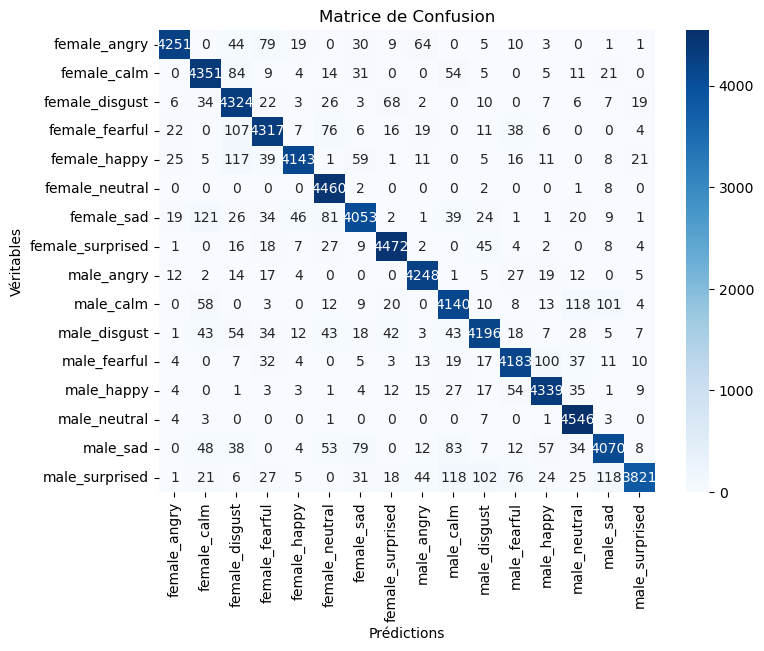

Rapport de classification :
                  precision    recall  f1-score   support

    female_angry       0.98      0.94      0.96      4516
     female_calm       0.93      0.95      0.94      4589
  female_disgust       0.89      0.95      0.92      4537
  female_fearful       0.93      0.93      0.93      4629
    female_happy       0.97      0.93      0.95      4462
  female_neutral       0.93      1.00      0.96      4473
      female_sad       0.93      0.91      0.92      4478
female_surprised       0.96      0.97      0.96      4615
      male_angry       0.96      0.97      0.97      4366
       male_calm       0.92      0.92      0.92      4496
    male_disgust       0.94      0.92      0.93      4554
    male_fearful       0.94      0.94      0.94      4445
      male_happy       0.94      0.96      0.95      4525
    male_neutral       0.93      1.00      0.96      4565
        male_sad       0.93      0.90      0.92      4505
  male_surprised       0.98      0.86      

In [185]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  
y_true_labels = np.argmax(Y_test, axis=1)  

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.title("Matrice de Confusion")
plt.show()

print("Rapport de classification :")
print(classification_report(y_true_labels, y_pred_labels, target_names=encoder.classes_))

In [160]:
test_index = 0  
audio_features = X_test[test_index] 
true_label = Y_test[test_index]

audio_features = np.expand_dims(audio_features, axis=0) 

prediction = model.predict(audio_features)
predicted_label_index = np.argmax(prediction)

true_label_decoded = encoder.inverse_transform([np.argmax(true_label)])
predicted_label = encoder.inverse_transform([predicted_label_index])

print(" Résultats du test :")
print(f" Vraie étiquette : {true_label_decoded[0]}")
print(f" Étiquette prédite : {predicted_label[0]}")
print(f" Probabilités prédites : {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
 Résultats du test :
 Vraie étiquette : male_calm
 Étiquette prédite : male_calm
 Probabilités prédites : [[5.0509320e-15 1.6638495e-03 0.0000000e+00 1.8813548e-33 5.5884526e-11
  3.8618535e-05 1.5381560e-05 1.3987884e-08 1.0502891e-12 8.7272233e-01
  2.2451673e-05 5.7031997e-07 2.9918286e-03 2.0777479e-07 1.1697191e-01
  5.5729020e-03]]


In [126]:
model.save("lstm_model.h5")

print("Model and weights saved to disk.")


Model and weights saved to disk.
